**Data Understanding**

In [1]:
import os
base_dir = 'flowers'

In [2]:
print(os.listdir(base_dir))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


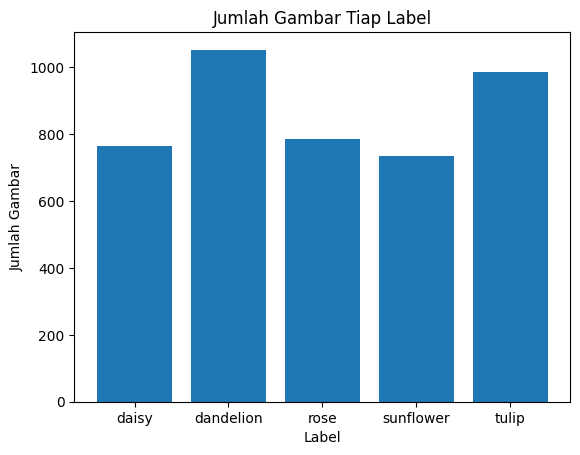

In [4]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

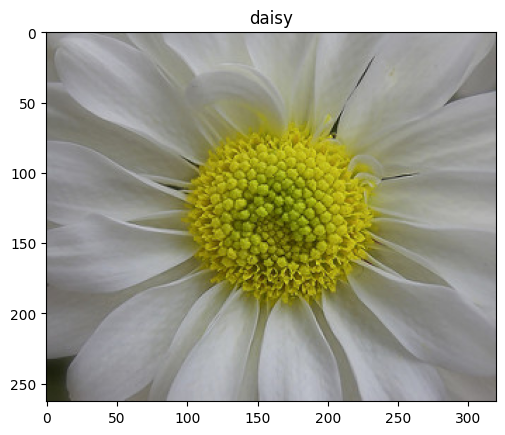

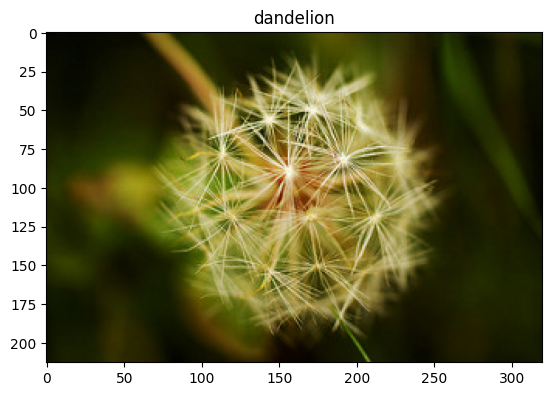

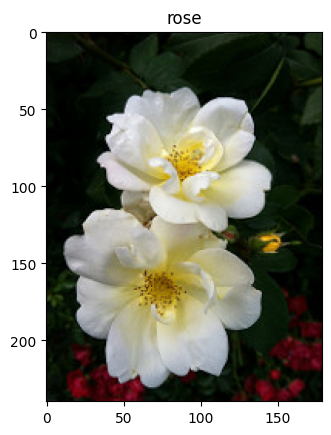

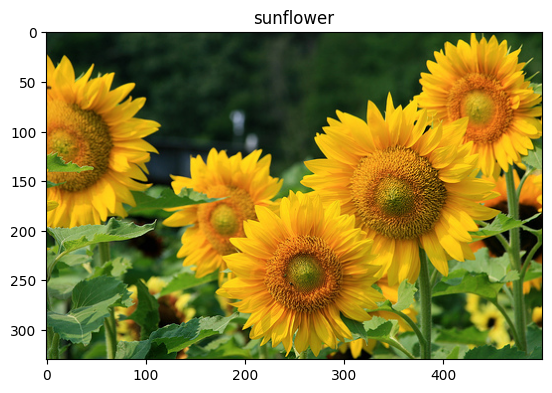

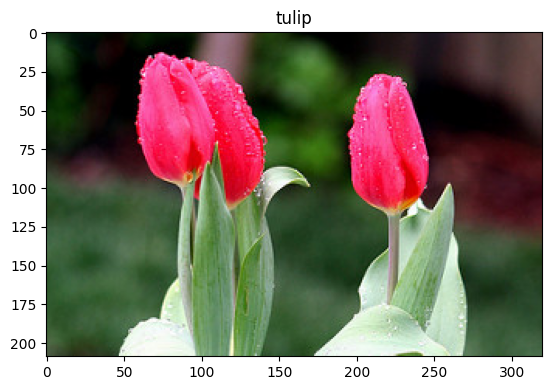

In [5]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

**Data Preparation**

In [8]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [9]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [10]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


In [11]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

# **Modelling**



## **Membuat Arsitektur CNN**

Penyusunan Layer

In [12]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model CNN

In [13]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 31s 166ms/step - loss: 1.3672 - accuracy: 0.3896 - val_loss: 1.1981 - val_accuracy: 0.5012
Epoch 2/20
109/109 [==============================] - 19s 176ms/step - loss: 1.1182 - accuracy: 0.5499 - val_loss: 1.0830 - val_accuracy: 0.5721
Epoch 3/20
109/109 [==============================] - 16s 150ms/step - loss: 0.9835 - accuracy: 0.6161 - val_loss: 0.9563 - val_accuracy: 0.6221
Epoch 4/20
109/109 [==============================] - 17s 152ms/step - loss: 0.9071 - accuracy: 0.6477 - val_loss: 1.0344 - val_accuracy: 0.5988
Epoch 5/20
109/109 [==============================] - 17s 159ms/step - loss: 0.8794 - accuracy: 0.6610 - val_loss: 0.9189 - val_accuracy: 0.6616
Epoch 6/20
109/109 [==============================] - 16s 149ms/step - loss: 0.8233 - accuracy: 0.6818 - val_loss: 0.8617 - val_accuracy: 0.6744
Epoch 7/20
109/109 [==============================] - 16s 150ms/step - loss: 0.7851 - accuracy: 0.6997 - val_loss: 0.8731 - val_ac

Evaluasi Model CNN

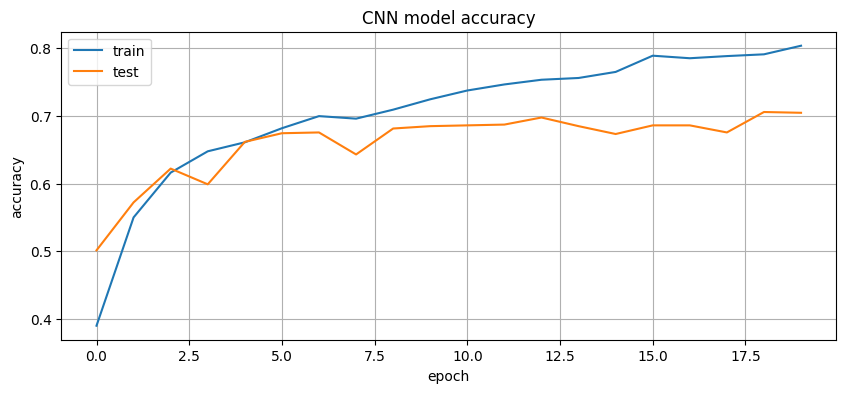

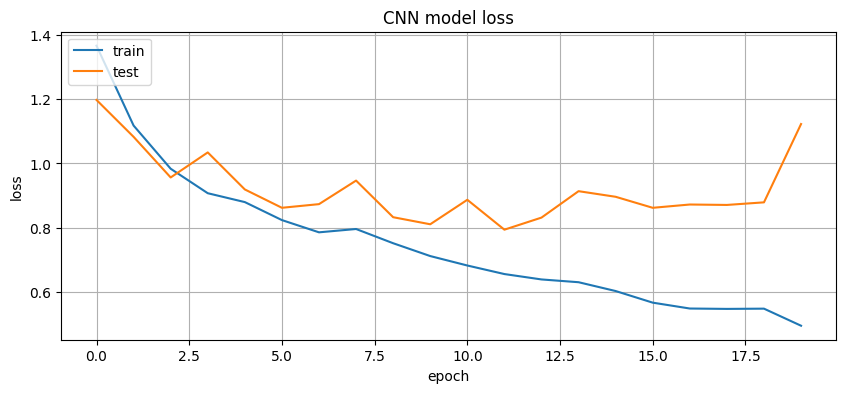

In [14]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**## Transfer Learning Menggunakan VGG16**

Memuat Model VGG16

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

58889256/58889256 [==============================] - 4s 0us/step


Melatih Model

In [16]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=10,
    validation_data = valid_data
)

Epoch 1/10
109/109 [==============================] - 33s 245ms/step - loss: 1.1049 - accuracy: 0.5670 - val_loss: 0.6999 - val_accuracy: 0.7384
Epoch 2/10
109/109 [==============================] - 20s 182ms/step - loss: 0.7388 - accuracy: 0.7232 - val_loss: 0.6262 - val_accuracy: 0.7849
Epoch 3/10
109/109 [==============================] - 20s 187ms/step - loss: 0.7327 - accuracy: 0.7298 - val_loss: 0.5812 - val_accuracy: 0.7884
Epoch 4/10
109/109 [==============================] - 21s 188ms/step - loss: 0.6617 - accuracy: 0.7567 - val_loss: 0.6395 - val_accuracy: 0.7616
Epoch 5/10
109/109 [==============================] - 20s 183ms/step - loss: 0.6760 - accuracy: 0.7457 - val_loss: 0.5725 - val_accuracy: 0.7930
Epoch 6/10
109/109 [==============================] - 21s 188ms/step - loss: 0.6258 - accuracy: 0.7712 - val_loss: 0.5722 - val_accuracy: 0.7965
Epoch 7/10
109/109 [==============================] - 22s 197ms/step - loss: 0.6033 - accuracy: 0.7726 - val_loss: 0.6101 - val_ac

Evaluasi Model

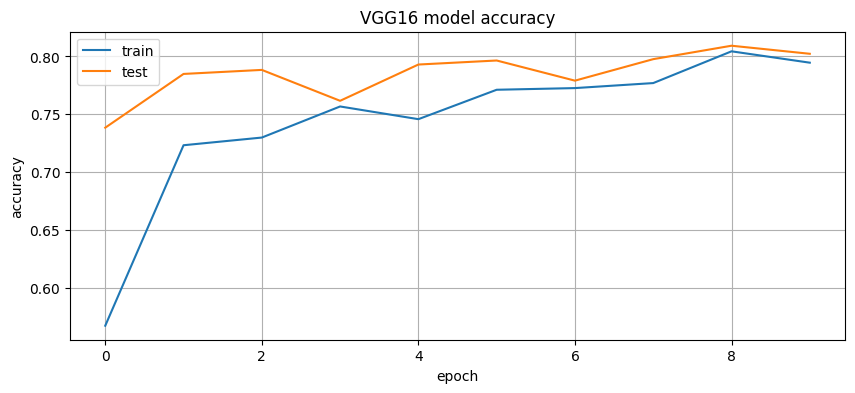

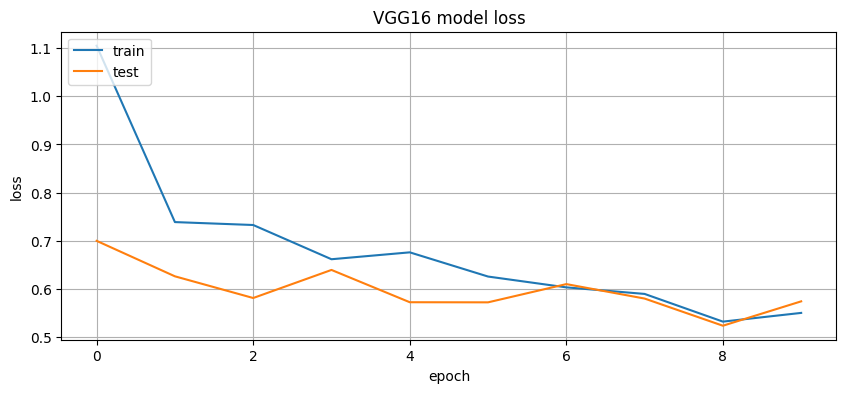

In [17]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Transfer Learning Menggunakan ResNet50

Memuat Model ResNet50

In [18]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

94765736/94765736 [==============================] - 7s 0us/step


Melatih Model

In [19]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=10,
    validation_data = valid_data
)

Epoch 1/10
109/109 [==============================] - 27s 192ms/step - loss: 1.6867 - accuracy: 0.2546 - val_loss: 1.5359 - val_accuracy: 0.2872
Epoch 2/10
109/109 [==============================] - 18s 163ms/step - loss: 1.5693 - accuracy: 0.3089 - val_loss: 1.4482 - val_accuracy: 0.4140
Epoch 3/10
109/109 [==============================] - 18s 168ms/step - loss: 1.5459 - accuracy: 0.3309 - val_loss: 1.4444 - val_accuracy: 0.3791
Epoch 4/10
109/109 [==============================] - 18s 163ms/step - loss: 1.5117 - accuracy: 0.3159 - val_loss: 1.4498 - val_accuracy: 0.3674
Epoch 5/10
109/109 [==============================] - 20s 182ms/step - loss: 1.5261 - accuracy: 0.3422 - val_loss: 1.4926 - val_accuracy: 0.3430
Epoch 6/10
109/109 [==============================] - 18s 164ms/step - loss: 1.4953 - accuracy: 0.3518 - val_loss: 1.4635 - val_accuracy: 0.3733
Epoch 7/10
109/109 [==============================] - 18s 163ms/step - loss: 1.4744 - accuracy: 0.3662 - val_loss: 1.4001 - val_ac

Evaluasi Model

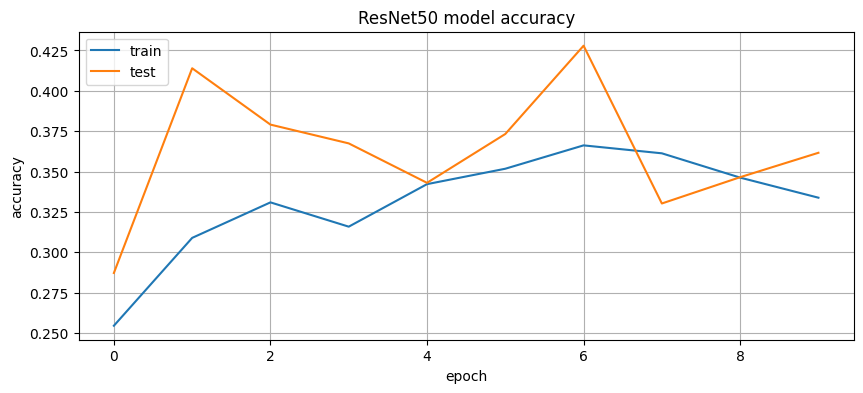

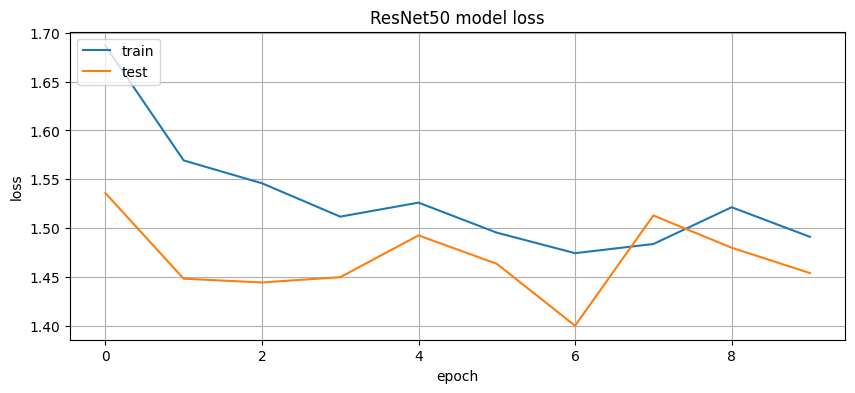

In [20]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## **Transfer Learning Menggunakan DenseNet201**

Memuat Model DenseNet201

In [21]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 4s 0us/step


In [22]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

Melatih Model

In [23]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 42s 250ms/step - loss: 0.8588 - accuracy: 0.6833 - val_loss: 0.4053 - val_accuracy: 0.8512
Epoch 2/20
109/109 [==============================] - 20s 183ms/step - loss: 0.5640 - accuracy: 0.7975 - val_loss: 0.3506 - val_accuracy: 0.8756
Epoch 3/20
109/109 [==============================] - 19s 176ms/step - loss: 0.4288 - accuracy: 0.8429 - val_loss: 0.3719 - val_accuracy: 0.8686
Epoch 4/20
109/109 [==============================] - 20s 182ms/step - loss: 0.4182 - accuracy: 0.8496 - val_loss: 0.5445 - val_accuracy: 0.8198
Epoch 5/20
109/109 [==============================] - 21s 190ms/step - loss: 0.4059 - accuracy: 0.8565 - val_loss: 0.3304 - val_accuracy: 0.8884
Epoch 6/20
109/109 [==============================] - 19s 176ms/step - loss: 0.3740 - accuracy: 0.8635 - val_loss: 0.4272 - val_accuracy: 0.8616
Epoch 7/20
109/109 [==============================] - 20s 181ms/step - loss: 0.3852 - accuracy: 0.8597 - val_loss: 0.4186 - val_ac

Evaluasi Model

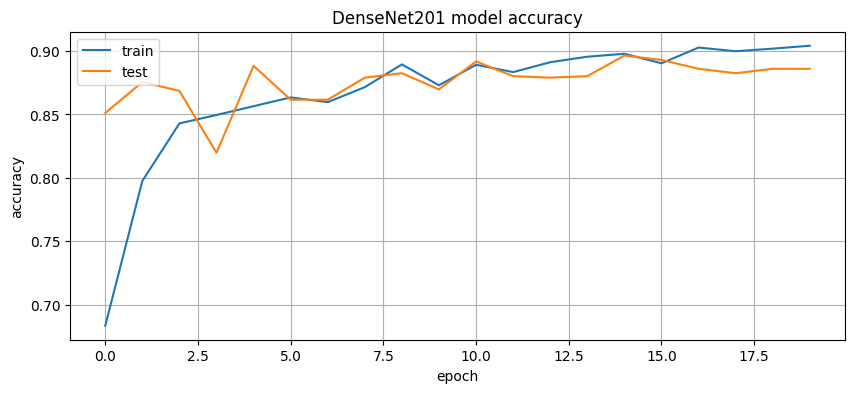

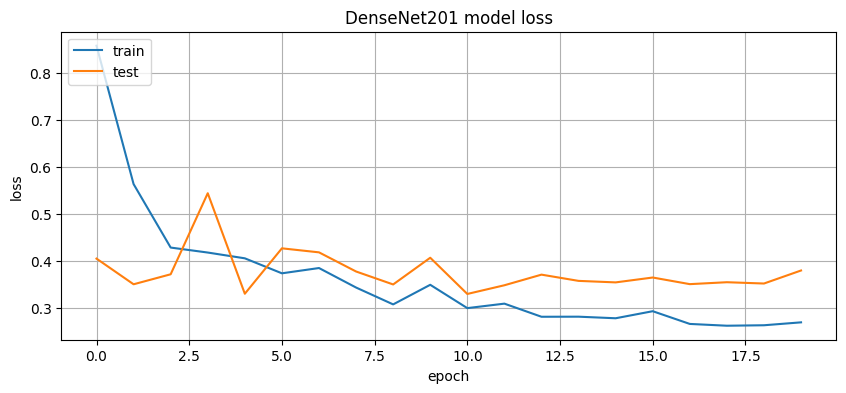

In [24]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

# **Evaluation**

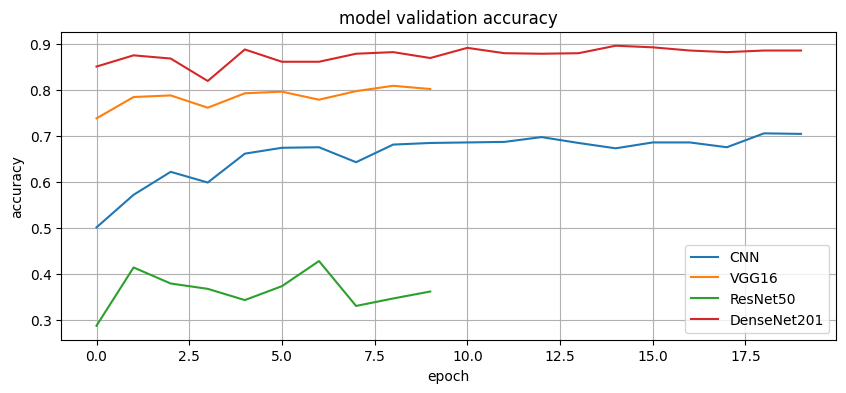

In [25]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

# **Uji Coba Model**

In [26]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Saving 44079668_34dfee3da1_n.jpg to 44079668_34dfee3da1_n.jpg
1/1 [==============================] - 0s 190ms/step
44079668_34dfee3da1_n.jpg
sunflower


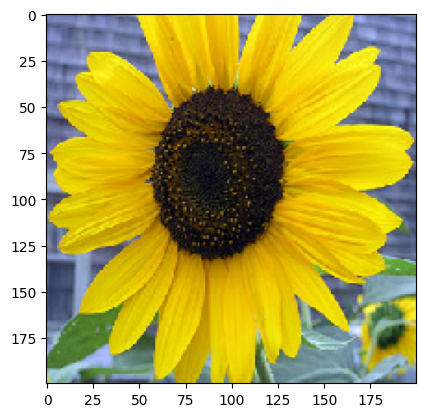

In [27]:
# Menguji coba model
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = vgg_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')